In [5]:
%pip install openpyxl catboost scikit-learn -q optuna
# %pip install numpy==1.24.1
%pip install joblib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score, fbeta_score

import optuna
import shap

from catboost import CatBoostClassifier, CatBoostRegressor, Pool
import joblib
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [7]:
raw_data = pd.read_excel('https://github.com/Jodode/student_scoring/raw/main/scoring_data.xlsx')

In [8]:
print(f'Количество уникальных хешей и ЛД: {len(raw_data["hash"].unique())} и {len(raw_data["Номер ЛД"].unique())}')

Количество уникальных хешей и ЛД: 9085 и 9098


In [9]:
def cast_types(df):

    df = df.drop(columns=['hash', ])
    
    grades_dict = {'Отлично': 5, np.nan: 2, 'зачтено': 3, 'Хорошо': 4, 'не зачтено': 2,
     'Неявка': 2, 'Неудовлетворительно': 2, 'Удовлетворительно': 3,
     'Не допущен': 2, 'Неявка по ув.причине': 2}

    # df['Полугодие'] = df['Полугодие'].map({'I полугодие' : 1, 'II полугодие' : 2})
    
    df['Оценка (без пересдач)'] = df['Оценка (без пересдач)'].map(grades_dict)
    df['Оценка (успеваемость)'] = df['Оценка (успеваемость)'].map(grades_dict)

    major_to_uni = {
        'Бизнес-информатика': 'ИКН',
        'Информатика и вычислительная техника': 'ИКН',
        'Информатика и вычислительная техника (ИВТ, ИСТ, ПИ)': 'ИКН',
        'Информационные системы и технологии': 'ИКН',
        'Прикладная информатика': 'ИКН',
        'Прикладная математика': 'ИКН',
        'Горное дело': 'Горный',
        'Геотехнологии (Горное дело, Физические процессы горного или нефтегазового производства)': 'Горный',
        'Техносферная безопасность': 'Горный',
        'Электроэнергетика и электротехника': 'Горный',
        'Физические процессы горного или нефтегазового производства': 'Горный',
        'Технологические машины и оборудование': 'ИТ',
        'Наноматериалы': 'ИНМ',
        'Электроника и наноэлектроника': 'ИНМ',
        'Материаловедение и технологии материалов': 'ИНМ',
        'Физика': 'ИНМ',
        'Экономика и управление (Экономика,Менеджмент)': 'ИЭУ',
        'Экономика': 'ИЭУ',
        'Менеджмент': 'ИЭУ',
        'Металлургия': 'ИТ',
        'Лингвистика': 'ИБО',
        'Нанотехнологии и микросистемная техника': 'ИНМ', 
        'Нанотехнологии и наноматериалы (Нанотехнологии и микросистемная техника, Наноматериалы)': 'ИНМ',
        'Стандартизация и метрология': 'ИТ',
        'Управление качеством': 'ИТ',
        'Управление в технических системах': 'ИТ',
        'Наземные транспортно-технологические средства': 'ИТ'
    }
    
    df['Институт'] = df['Специальность/направление'].apply(lambda x: major_to_uni[x])
    
    df['Уровень подготовки'] = df['Уровень подготовки'].apply(lambda x: 'Бакалавр' if x == 'Академический бакалавр' else x) 
    df = df[~df['Учебный год'].isin(['2024 - 2025', '2025 - 2026', '2026 - 2027', '2027 - 2028'])]

    return df

def feature_eng(df):
    df['Год начала обучения'] = df['Учебная группа'].str.extract(r'(\d{2})').astype(int) + 2000
    df['Год начала семестра'] = df['Учебный год'].str.split(' - ').str[0].astype(int)
    
    def calculate_semester(row):
            year_difference = row['Год начала семестра'] - row['Год начала обучения']
            return year_difference * 2 + 2 if row['Полугодие'] == 'II полугодие' else year_difference * 2 + 1
        
    df['Номер семестра'] = df.apply(calculate_semester, axis=1)
    
    df['Год начала семестра'] = df.apply(lambda x: x['Год начала семестра'] + 1 if x['Полугодие'] == 'II полугодие' else x['Год начала семестра'], axis=1)

    return df

def data_preproccess(df):
    data = df.pipe(cast_types).pipe(feature_eng)
    
    data = data[~(data['Учебный год'] == '2023 - 2024')]
    data["Дисциплина_encoded"] = data.groupby("Дисциплина")["Оценка (успеваемость)"].transform("mean")
    # train and test split
    # last semestr - target set, all previous - train data 
    test = data[((data['Полугодие'] == 'II полугодие') & (data['Учебный год'] == '2022 - 2023'))]
    train = data[~((data['Полугодие'] == 'II полугодие') & (data['Учебный год'] == '2022 - 2023'))]
    
    print(f'Соотношение тестовых и тренировочных данных - {round(test.shape[0] / train.shape[0], 2)} : {1 - round(test.shape[0] / train.shape[0], 2)}')    
    
    grade_counts = train.groupby(['Номер ЛД', 'Оценка (успеваемость)']).size().unstack(fill_value=0)
    total_grades = grade_counts.sum(axis=1)
    grade_shares = grade_counts.divide(total_grades, axis=0)
    
    
    train = train.join(grade_shares, on='Номер ЛД', rsuffix='_доля')
    test = test.join(grade_shares, on='Номер ЛД', rsuffix='_доля')
    
    return train, test

In [10]:
data = raw_data.pipe(cast_types).pipe(feature_eng)

In [11]:
train, test = data_preproccess(raw_data)

Соотношение тестовых и тренировочных данных - 0.38 : 0.62


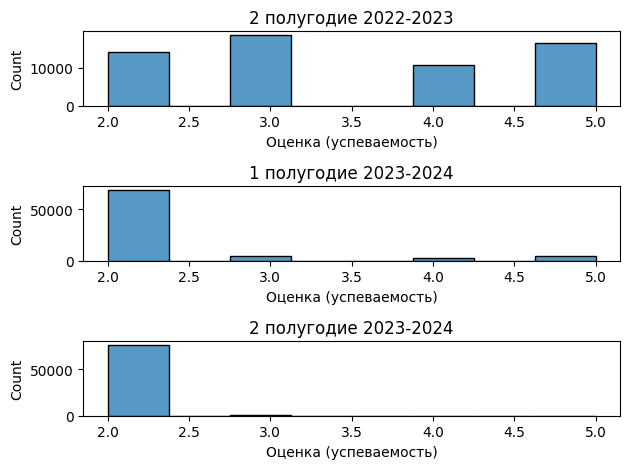

In [12]:
fig, axs = plt.subplots(3, 1)
sns.histplot(data=data[((data['Полугодие'] == 'II полугодие') & (data['Учебный год'] == '2022 - 2023'))], x='Оценка (успеваемость)', ax=axs[0], bins=8).set_title('2 полугодие 2022-2023')
sns.histplot(data=data[((data['Полугодие'] == 'I полугодие') & (data['Учебный год'] == '2023 - 2024'))], x='Оценка (успеваемость)', ax=axs[1], bins=8).set_title('1 полугодие 2023-2024')
sns.histplot(data=data[((data['Полугодие'] == 'II полугодие') & (data['Учебный год'] == '2023 - 2024'))], x='Оценка (успеваемость)', ax=axs[2], bins=8).set_title('2 полугодие 2023-2024')
fig.tight_layout();

In [13]:
train.sample(5)

,Номер ЛД,Уровень подготовки,Учебная группа,Специальность/направление,Учебный год,Полугодие,Дисциплина,Оценка (без пересдач),Оценка (успеваемость),Институт,Год начала обучения,Год начала семестра,Номер семестра,Дисциплина_encoded,2,3,4,5
26205,2003923,Специалист,СГД-20-6,Горное дело,2020 - 2021,II полугодие,Физика,2,2,Горный,2020,2021,2,3.591597,0.051282,0.384615,0.435897,0.128205
47184,2213968,Бакалавр,БФЗ-20-1,Физика,2022 - 2023,I полугодие,Методы исследования материалов,2,2,ИНМ,2020,2022,5,3.104651,0.142857,0.571429,0.261905,0.023810
111317,1904432,Бакалавр,БИСТ-20-2,Информационные системы и технологии,2020 - 2021,I полугодие,Физическая культура и спорт,2,3,ИКН,2020,2020,1,2.939116,0.046512,0.348837,0.348837,0.255814
117040,2008385,Бакалавр,БМТ-20-2,Металлургия,2022 - 2023,I полугодие,Основы теории литейных процессов,2,2,ИТ,2020,2022,5,2.090909,0.113636,0.295455,0.386364,0.204545
29310,2005925,Бакалавр,БИВТ-20-3,Информатика и вычислительная техника,2021 - 2022,I полугодие,Иностранный язык,4,4,ИКН,2020,2021,3,3.755892,0.000000,0.146341,0.317073,0.536585


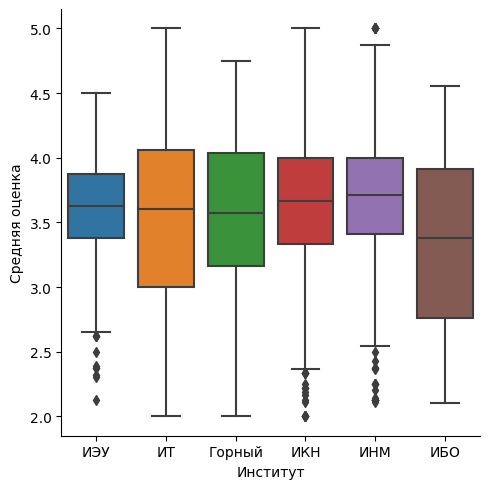

In [14]:
grouped_by_uni = train.groupby(by=['Номер ЛД', ])
mean_by_id = grouped_by_uni.apply(lambda x: x['Оценка (успеваемость)'].mean())
for_visual = pd.DataFrame({'Номер ЛД': np.array(mean_by_id.index), 'Средняя оценка': mean_by_id.values, 'Институт': grouped_by_uni.apply(lambda x: x['Институт'].unique()[0]).values})
sns.catplot(data=for_visual, x='Институт', y='Средняя оценка', kind='box')

In [15]:
mean_by_uni = for_visual.groupby('Институт')['Средняя оценка'].mean()

In [16]:
X_train = train.drop(columns=['Оценка (без пересдач)', 'Оценка (успеваемость)'])

X_test = test.drop(columns=['Оценка (без пересдач)', 'Оценка (успеваемость)'])

y_train_no_retakes = train['Оценка (без пересдач)']
y_train_performance = train['Оценка (успеваемость)']
y_test_no_retakes = test['Оценка (без пересдач)']
y_test_performance = test['Оценка (успеваемость)']

In [17]:
cat_features = X_train.columns.get_indexer(X_train.select_dtypes('object').columns)

train_pool = Pool(data=X_train, label=y_train_performance, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test_performance, cat_features=cat_features)

def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_loguniform('random_strength', 0.001, 10),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 10),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter'])
    }

    model = CatBoostClassifier(**param, verbose=0, random_state=42, loss_function='MultiClass', task_type="GPU")

    model.fit(train_pool, verbose=0)

    preds = model.predict(X_test)
    
    f2 = fbeta_score(y_test_performance, preds, average='weighted', beta=2)
    
    return f2

In [18]:
# study = optuna.create_study(direction='maximize')

# study.optimize(objective, n_trials=100)

# best_params = study.best_params
# print("Best parameters found: ", best_params)

In [19]:
params = {
'iterations': 404,
'depth': 10,
'learning_rate': 0.17378750867623877,
'l2_leaf_reg': 7.5011902088677616,
'border_count': 176,
'random_strength': 0.4096930346565832,
'bagging_temperature': 0.059478250984096016,
'od_type': 'IncToDec',
'random_state': 42,
'loss_function': 'MultiClass',
'task_type': 'GPU',
'verbose': 0}

In [20]:
model = CatBoostClassifier(**params)
model.fit(train_pool)

In [21]:
pred_performance_c = model.predict(X_test)
print(f'CBC report, RMSE: {np.sqrt(mean_squared_error(y_test_performance, pred_performance_c))}')
print(classification_report(y_test_performance, pred_performance_c))

CBC report, RMSE: 0.9364010266231216
              precision    recall  f1-score   support

           2       0.76      0.60      0.67     14225
           3       0.57      0.72      0.64     18780
           4       0.36      0.29      0.32     10803
           5       0.64      0.64      0.64     16564

    accuracy                           0.59     60372
   macro avg       0.58      0.56      0.57     60372
weighted avg       0.60      0.59      0.59     60372



<Axes: xlabel='importance', ylabel='feature'>

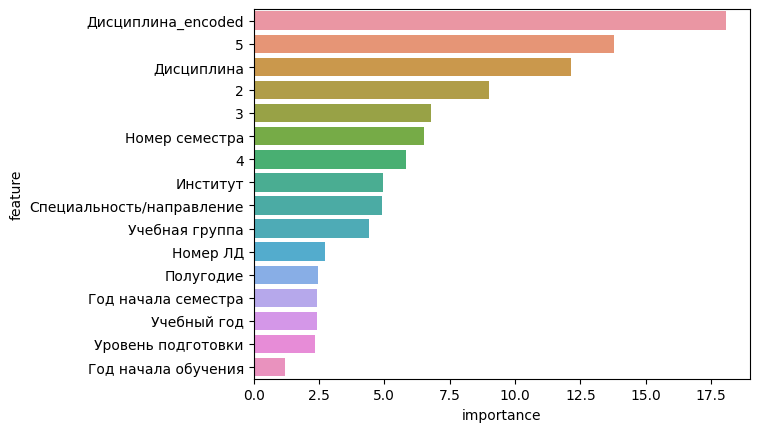

In [45]:
sns.barplot(
    data=pd.DataFrame({'importance': model.feature_importances_, 'feature': model.feature_names_}).sort_values(by=['importance',], ascending=False),
    x='importance',
    y='feature'
)

In [50]:
pd.concat([train, test]).to_csv('final_db_data.csv')

In [51]:
train.to_csv('final_train_data.csv')

In [ ]:
sns.histplot(data=train, x='Оценка (успеваемость)')

In [52]:
test.to_csv('final_test_data')

In [60]:
test['pred'] = pred_performance_c

In [66]:
np.sum(test.groupby(by=['Номер ЛД',]).apply(
    lambda x: x['Оценка (успеваемость)'].value_counts()[2] if 2 in x['Оценка (успеваемость)'].to_list() else 0) == test.groupby(by=['Номер ЛД',]).apply(
    lambda x: x['pred'].value_counts()[2] if 2 in x['pred'].to_list() else 0)) / test.shape[0]

0.05774199960246472

57%

In [ ]:
joblib.dump(model, 'final_cbc.pkl')